In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

def fHamiltonian(N,w1,w2,w3,alpha1,alpha2,alpha3,g13,g12,g23):
    
    # N is the demension of each qubit,w123 denotes the frequencies,alpha123 denotes the anharmonicity,
    # g denotes XY coupling strength, dont need to multiply 2pi
    
    a = destroy(N)
    a_dagger = create(N)  
    
    H_w1= w1 * tensor(a_dagger * a, qeye(N), qeye(N)) 
    H_a1= alpha1 / 2 * tensor(a_dagger * a_dagger * a * a, qeye(N), qeye(N))
    
    H_w2=  w2 * tensor( qeye(N),a_dagger * a, qeye(N)) 
    H_a2= alpha2 / 2 * tensor( qeye(N),a_dagger * a_dagger * a * a, qeye(N))
    
    H_w3=  w3 * tensor( qeye(N), qeye(N),a_dagger * a) 
    H_a3= alpha3 / 2 * tensor( qeye(N), qeye(N),a_dagger * a_dagger * a * a)
    
    # print("H_w1 = {}".format(H_w1))
    # print("H_w2 = {}".format(H_w2))
    # print("H_w3 = {}".format(H_w3))
    # print("H_q = {}".format(H_w1 + H_w2 + H_w3))

    H_13 = g13 * tensor(a+a_dagger,qeye(N),a+a_dagger)
    H_12 = g12 * tensor(a + a_dagger, a + a_dagger, qeye(N))
    H_23 = g23 * tensor(qeye(N), a + a_dagger, a + a_dagger)

    # print("H_13 = {}".format(H_13))
    # print("H_12 = {}".format(H_12))
    # print("H_23 = {}".format(H_23))
    # print("H_inter = {}".format(H_13 + H_12 + H_23))


    H_com= (H_w1+H_a1+H_w2+H_a2+H_w3+H_a3+H_12+H_23+H_13)*np.pi*2
    
    return H_com, [[H_w1, H_w2, H_w3], [H_a1, H_a2, H_a3]]

def feigen(H,n1,n2,n3,N):
    
    # N is the demension of each qubit,n1 n2 n3 denotes the photon number on qubit123,H is the Hamiltonian
    print("state_index2 = {}".format(n1*N*N+n2*N+n3))
    eigenlist=[np.abs(arr[n1*N*N+n2*N+n3][0][0].real) for arr in H.eigenstates()[1]]
    max_value=max(eigenlist)
    max_index = None
                  
    for index, value in enumerate(eigenlist):
        if value == max_value:
            max_index = index
            break
            
            ### output: state in qobj, energylevel magnitude, index number of the energylevel
            
    return [H.eigenstates()[1][max_index],H.eigenenergies()[max_index]/np.pi/2,max_index]
            

    
def HXYpulse(N,H_static,tg,t1,qn,ampl,freq):
    
    ampl=ampl*2*np.pi
    
    def mpulse(t, args): 
        if t<t1:
            return ampl * np.cos(freq*np.pi*2*t)* (1/2-1/2*np.cos(np.pi*t/t1))
        if t1<=t<=tg-t1:
            return ampl * np.cos(freq*np.pi*2*t)
        if tg-t1<t:
            return ampl * np.cos(freq*np.pi*2*t)* (1/2-1/2*np.cos(np.pi*(t-tg+2*t1)/t1))
        
    a = destroy(N)
    a_dagger = create(N)  
    
    if qn==1:
        HXY=[H_static,[tensor(a+a_dagger,qeye(N), qeye(N)), mpulse]]
    if qn==2:
        HXY=[H_static,[tensor(qeye(N),a+a_dagger, qeye(N)), mpulse]]
    if qn==3:
        HXY=[H_static,[tensor(qeye(N), qeye(N),a+a_dagger), mpulse]]
        
    return HXY

def HZpulse(N,H_static,tg,qn,ampl):
    
    ### half sin shape

    def fpulse(t, args): 
        return ampl * np.sin(np.pi*t/t1)
    
    a = destroy(N)
    a_dagger = create(N)  
    
    if qn==1:
        HZ=[H_static,[tensor(a_dagger*a,qeye(N), qeye(N)), fpulse]]
    if qn==2:
        HZ=[H_static,[tensor(qeye(N),a_dagger*a, qeye(N)), fpulse]]
    if qn==3:
        HZ=[H_static,[tensor(qeye(N), qeye(N),a_dagger*a), fpulse]]

    return HZ


def coplist(N,G1up,G1down,G1Z,G2up,G2down,G2Z,G3up,G3down,G3Z):
    
    ao= destroy(N)
    ad= create(N)

    cop1up = np.sqrt(G1up)*tensor(ad,qeye(N),qeye(N))
    cop1down = np.sqrt(G1down)*tensor(ao,qeye(N),qeye(N))
    cop1Z = np.sqrt(G1Z)*tensor(ad*ao,qeye(N),qeye(N))
    cop2up = np.sqrt(G2up)*tensor(qeye(N),ad,qeye(N))
    cop2down = np.sqrt(G2down)*tensor(qeye(N),ao,qeye(N))
    cop2Z = np.sqrt(G2Z)*tensor(qeye(N),qeye(N),ad*ao)
    cop3up = np.sqrt(G3up)*tensor(qeye(N),qeye(N),ad)
    cop3down = np.sqrt(G3down)*tensor(qeye(N),qeye(N),ao)
    cop3Z = np.sqrt(G3Z)*tensor(qeye(N),qeye(N),ad*ao)
    
    return [cop1up,cop1down,cop1Z,cop2up,cop2down,cop2Z,cop3up,cop3down,cop3Z]


    
    
def seoutput(H_d,tg,step,state):
    tlist=np.linspace(0, tg, step)
 
    option = Options(rtol=1e-8)
        
    output = mesolve(H_d, state, tlist, [], [], options=option)
    
    # result1 = np.angle(state.dag() * output.states[-1])
        
    return output

def meoutput(H_d,tg,step,state,coplist):
    tlist=np.linspace(0, tg, step)
 
    option = Options(rtol=1e-8)
        
    output = mesolve(H_d, state, tlist, coplist, [], options=option)

        
    return output



def dlist(output,step,state2):

    
    datalist=[]
    for ii in range(0,step):
        datalist.append(np.abs(((output.states[ii]).dag()*state2)[0][0][0])**2)
        
    return datalist


def dlist_density(output,step,state2):

    
    datalist=[]
    for ii in range(0,step):
        datalist.append(((output.states[ii] * output.states[ii].dag()) * (state2 * state2.dag())).tr())
        
    return datalist
    



# basic information

## ZZ

In [2]:
import revised_ver.qubit_system as qs
def g2matrix(g_dic):
    n = len(g_dic)
    g = [[0] * n for _ in range(n)]
    
    for i, key_i in enumerate(g_dic):
        for j, key_j in enumerate(g_dic):
            if j >= i:
                g[i][j] = g_dic.get(f"g{i+1}{j+1}", 0)
    
    return g

In [13]:
N = 4 # Maximum excitation level
w = [7, 0, 0] # Qubit frequency
alpha =[-0.24, -0.14, -0.24] # Anharmonicity
g_dic = {
    "g12": 0.11,
    "g13": -0.006,
    "g23": 0.11
}
g = g2matrix(g_dic) # Coupling strength
print("g = {}".format(g))
gamma_list = None # Gamma up, Gamma down, Gamma z

system_1 = qs.qubit_system(N,w,alpha,g,gamma_list)
check_q, check_a = system_1.check_list

g = [[0, 0.11, -0.006], [0, 0, 0.11], [0, 0, 0]]


In [3]:
# import sys
# np.set_printoptions(threshold=sys.maxsize)
H, [check_q_2, check_a_2]=fHamiltonian(4,7,0,0,-0.24,-0.14,-0.24,-0.006,0.11,0.11)
print("==========")

In [8]:
N = 4 # Maximum excitation level
w = [0, 0, 0] # Qubit frequency
alpha =[-0.24, -0.14, -0.24] # Anharmonicity
g_dic = {
    "g12": 0.11,
    "g13": -0.006,
    "g23": 0.11
}
g = g2matrix(g_dic) # Coupling strength
print("g = {}".format(g))
gamma_list = None # Gamma up, Gamma down, Gamma z

xxlen = 3
xx_list = np.linspace(5, 8, xxlen)  
yylen = 3
yy_list = np.linspace(6.6, 7.4, yylen)  

zzlist= np.zeros((xxlen,yylen))
index_list = []

for yy,j in zip(yy_list,range(len(yy_list))):
    
    H1a, _=fHamiltonian(4,0,5,0,0,0,0,0,0,0)
    H1b, _ =fHamiltonian(4,0,0,yy,0,0,0,0,0,0)        
    H2=H+H1a+H1b
    # H_1ab, _ = fHamiltonian(4,0,5,yy,0,0,0,0,0,0)
    # print(H_1ab == H1a+H1b)
    # w = [7,5,yy]
    # system_2 = qs.qubit_system(N,w,alpha,g,gamma_list)
    # print(system_2.H == H+H1a+H1b)

    index11=feigen(H2,1,0,1,4)[2]
    index10=feigen(H2,1,0,0,4)[2]
    index01=feigen(H2,0,0,1,4)[2]
    index00=feigen(H2,0,0,0,4)[2]  

    # index_101 = system_2.get_eigenstates_energy([1,0,1])[2]
    # index_100 = system_2.get_eigenstates_energy([1,0,0])[2]
    # index_001 = system_2.get_eigenstates_energy([0,0,1])[2]
    # index_000 = system_2.get_eigenstates_energy([0,0,0])[2]

    # index_list.append([index11==index_101, index10==index_100, index01==index_001, index00==index_000])
    for xx, i in zip(xx_list,range(len(xx_list))):
    
        H1a, _=fHamiltonian(4,0,xx,0,0,0,0,0,0,0)
        H1b, _=fHamiltonian(4,0,0,yy,0,0,0,0,0,0)        
        H2=H+H1a+H1b

        eigene11=H2.eigenenergies()[index11]/np.pi/2
        eigene10=H2.eigenenergies()[index10]/np.pi/2
        eigene01=H2.eigenenergies()[index01]/np.pi/2       
        eigene00=H2.eigenenergies()[index00]/np.pi/2

        zzlist[i][j]=(-eigene11+eigene10+eigene01-eigene00)
        
    # print(yy)


g = [[0, 0.11, -0.006], [0, 0, 0.11], [0, 0, 0]]
state_index2 = 17
state_index2 = 16
state_index2 = 1
state_index2 = 0
state_index = 17
state_index = 16
state_index = 1
state_index = 0
True
state_index = 17
state_index = 16
state_index = 1
state_index = 0
True
state_index = 17
state_index = 16
state_index = 1
state_index = 0
True
state_index2 = 17
state_index2 = 16
state_index2 = 1
state_index2 = 0
state_index = 17
state_index = 16
state_index = 1
state_index = 0
True
state_index = 17
state_index = 16
state_index = 1
state_index = 0
True
state_index = 17
state_index = 16
state_index = 1
state_index = 0
True
state_index2 = 17
state_index2 = 16
state_index2 = 1
state_index2 = 0
state_index = 17
state_index = 16
state_index = 1
state_index = 0
True
state_index = 17
state_index = 16
state_index = 1
state_index = 0
True
state_index = 17
state_index = 16
state_index = 1
state_index = 0
True


In [7]:
index_list

[[True, True, True, True],
 [True, True, True, True],
 [False, False, False, True],
 [True, True, True, True],
 [True, False, False, True],
 [False, False, False, True],
 [True, True, True, True],
 [True, True, True, True],
 [False, False, False, True]]

<ipython-input-3-99421b000eb1>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p1 = ax1.pcolor(xxx, yyy, zzlist.T, cmap=matplotlib.cm.viridis_r,norm=nrm1)


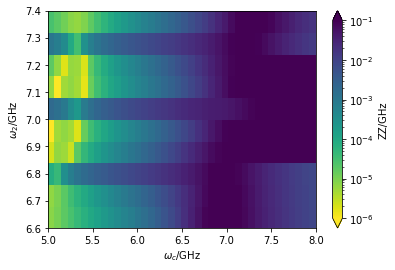

In [3]:
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.ticker as tc
import matplotlib

xxx,yyy = np.meshgrid(xx_list,yy_list)

nrm1 = matplotlib.colors.LogNorm(1e-6, 1e-1)  

zzlist=np.abs(zzlist)

fig1, ax1 = plt.subplots()
p1 = ax1.pcolor(xxx, yyy, zzlist.T, cmap=matplotlib.cm.viridis_r,norm=nrm1)
cb1 = fig1.colorbar(p1, ax=ax1,label='ZZ/GHz', extend='both')
ax1.set_xlabel('$\omega_c$/GHz')
ax1.set_ylabel('$\omega_2$/GHz')



# np.savez('C:/Users/HP/Desktop/data/zzcancelampl2.npz',k_outlistF = out_listF,k_outlistallangle = out_listallangle)   

plt.show()

## energy level

In [3]:
H=fHamiltonian(4,5,0,4.7,-0.24,-0.14,-0.24,0.006,0.11,0.11)
num=20   ####number of energy level you want to see
xxlen = 101
xx_list = np.linspace(5, 7, xxlen)  ###scan range
elevel_list= np.zeros((xxlen,num))
for xx, i in zip(xx_list,range(len(xx_list))):
    H1=fHamiltonian(4,0,xx,0,0,0,0,0,0,0)
    H2=H+H1
    
    for j in range(0,num):
        elevel_list[i][j]=H2.eigenenergies()[j] / (2 * np.pi)

Text(0, 0.5, 'energylevel')

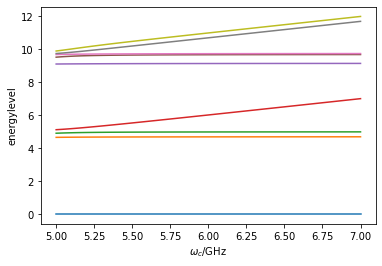

In [4]:
for j in range(0,9):
    plt.plot(xx_list,[v[j] for v in elevel_list])
    
plt.xlabel('$\omega_c$/GHz')
plt.ylabel('energylevel')

# dynamic

## microwave drive on coupler

In [10]:
H,_=fHamiltonian(4,6.3,5.85,6.2,-0.3,-0.3,-0.2,-0.005,0.05,0.05)

e101=feigen(H,1,0,1,4)[1]
st101=feigen(H,1,0,1,4)[0]

e100=feigen(H,1,0,0,4)[1]
st100=feigen(H,1,0,0,4)[0]

e001=feigen(H,0,0,1,4)[1]
st001=feigen(H,0,0,1,4)[0]

e000=feigen(H,0,0,0,4)[1]
st000=feigen(H,0,0,0,4)[0]

e010=feigen(H,0,1,0,4)[1]


state_index2 = 17
state_index2 = 17
state_index2 = 16
state_index2 = 16
state_index2 = 1
state_index2 = 1
state_index2 = 0
state_index2 = 0
state_index2 = 4


In [14]:
e010-e000

5.837099878968836

state_index2 = 0
state_index2 = 0


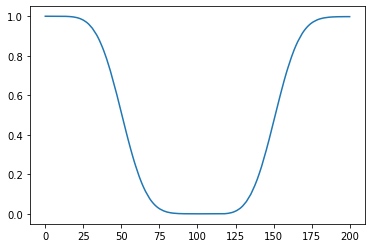

In [18]:
HXY=HXYpulse(4,H,100,50,2,0.01,e010-e000)
output=seoutput(HXY,200,2000,feigen(H,0,0,0,4)[0])
datalist=dlist(output,2000,feigen(H,0,0,0,4)[0])
xxlist=np.linspace(0,200,2000)
plt.plot(xxlist,datalist)